## **Democracy Index Clustering Analysis**

**Author:** Rosalina Torres  
**Course:** IE6400 – Data Analytics Engineering, Northeastern University  
**Term:** Spring 2025

📧 [torres.ros@northeastern.edu](mailto:torres.ros@northeastern.edu)  
🔗 [LinkedIn](https://www.linkedin.com/in/rosalina2) | [GitHub](https://github.com/rosalinatorres888m)

## Project Overview
This project demonstrates how machine learning algorithms naturally discover political regime patterns that align with expert classifications. Using unsupervised learning techniques, I analyzed the Economist Intelligence Unit's Democracy Index to reveal key insights about democratic dimensions and identify borderline countries at risk of democratic backsliding.

## Key Findings

-Natural Clustering: Machine learning algorithms discovered four distinct clusters that closely align with expert-defined regime types

-Critical Dimensions: Civil liberties (0.90) and electoral processes (0.86) emerged as the most powerful predictors of regime type

-Borderline Cases: Countries like Hungary and Poland occupy a statistical gray zone between flawed democracies and hybrid regimes

-US Downgrade: Analysis reveals weaknesses in US democratic functioning and political culture that led to its downgrade from full to flawed democracy


## Import Libraries

In [1]:
# Core data manipulation and analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# Visualization libraries
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.width', 160)

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading and Initial Exploration

For this analysis, I'll use the Economist Intelligence Unit's Democracy Index data. Let's load the data and explore its structure.

**Note:** You'll need to download the Democracy Index data. The EIU publishes this data annually, but you may need to create a cleaned CSV format or locate a pre-processed version.

In [2]:


# Load democracy index data
# Note: Replace 'democracy_index_data.csv' with your actual file path
try:
    df = pd.read_csv('/Users/rosalinatorres/Downloads/democracy_index (1).csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("File not found. Please ensure the data file is in the correct location.")
    print("Creating example data for demonstration purposes...")
    
    # Create mock data for demonstration if file is not available
    # This is for illustration only - replace with actual Democracy Index data
    countries = [
        'Sweden', 'Norway', 'Denmark', 'United States', 'Canada', 'United Kingdom', 
        'Germany', 'France', 'Italy', 'Spain', 'Japan', 'Australia', 'New Zealand',
        'Brazil', 'Mexico', 'India', 'South Africa', 'Turkey', 'Russia', 'China',
        'Saudi Arabia', 'Iran', 'Venezuela', 'Cuba', 'North Korea'
    ]
    
    # ISO3 codes for the example countries
    iso3_codes = [
        'SWE', 'NOR', 'DNK', 'USA', 'CAN', 'GBR', 'DEU', 'FRA', 'ITA', 'ESP', 
        'JPN', 'AUS', 'NZL', 'BRA', 'MEX', 'IND', 'ZAF', 'TUR', 'RUS', 'CHN',
        'SAU', 'IRN', 'VEN', 'CUB', 'PRK'
    ]
    
    # Define regime types for the examples
    regime_types = [
        'Full democracy', 'Full democracy', 'Full democracy', 'Flawed democracy', 'Full democracy', 'Full democracy',
        'Full democracy', 'Flawed democracy', 'Flawed democracy', 'Flawed democracy', 'Flawed democracy', 'Full democracy', 'Full democracy',
        'Flawed democracy', 'Flawed democracy', 'Flawed democracy', 'Flawed democracy', 'Hybrid regime', 'Authoritarian regime', 'Authoritarian regime',
        'Authoritarian regime', 'Authoritarian regime', 'Authoritarian regime', 'Authoritarian regime', 'Authoritarian regime'
    ]
    
    # Create numeric mapping for regime types
    regime_mapping = {
        'Full democracy': 0,
        'Flawed democracy': 1,
        'Hybrid regime': 2,
        'Authoritarian regime': 3
    }
    
    # Create dataframe with mock data
    n_countries = len(countries)
    np.random.seed(42)  # For reproducibility
    
    data = {
        'country': countries,
        'ISO3': iso3_codes,
        'year': [2023] * n_countries,
        'regime_type': regime_types,
        'regime_type_numeric': [regime_mapping[rt] for rt in regime_types],
    }
    
    # Create reasonable values for each dimension based on regime type
    dimensions = ['electoral_process', 'functioning_govt', 'political_participation', 
                  'political_culture', 'civil_liberties']
    
    # Set ranges for each regime type to simulate realistic data
    for dim in dimensions:
        data[dim] = np.zeros(n_countries)
        
    for i, regime in enumerate(regime_types):
        if regime == 'Full democracy':
            for dim in dimensions:
                data[dim][i] = np.random.uniform(8.0, 10.0)
        elif regime == 'Flawed democracy':
            for dim in dimensions:
                data[dim][i] = np.random.uniform(6.0, 8.0)
        elif regime == 'Hybrid regime':
            for dim in dimensions:
                data[dim][i] = np.random.uniform(4.0, 6.0)
        else:  # Authoritarian regime
            for dim in dimensions:
                data[dim][i] = np.random.uniform(1.0, 4.0)
    
    # Add some variation to make it more realistic
    for i in range(n_countries):
        # Choose a random dimension to adjust
        dim_to_adjust = np.random.choice(dimensions)
        # Adjust up or down by up to 2 points (but keep in 0-10 range)
        adjustment = np.random.uniform(-2, 2)
        data[dim_to_adjust][i] = np.clip(data[dim_to_adjust][i] + adjustment, 0, 10)
    
    # Calculate overall democracy index (average of the five dimensions)
    data['democracy_index'] = np.mean([data[dim] for dim in dimensions], axis=0)
    
    df = pd.DataFrame(data)
    print("Example data created successfully!")

Data loaded successfully!


## Basic exploration to understand structure

In [3]:
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Number of countries: {df['country'].nunique()}")

# Display the first few rows
df.head()

Dataset shape: (167, 10)
Columns: ['Unnamed: 0', 'rank', 'country', 'democracy_index', 'electoral_processand_pluralism', 'functioning_of_government', 'political_participation', 'political_culture', 'civil_liberties', 'category']
Number of countries: 167


Unnamed: 0 rank      country  democracy_index  electoral_processand_pluralism  functioning_of_government  political_participation  political_culture  \
0           0    1       Norway             9.87                           10.00                       9.64                    10.00              10.00   
1           1    2      Iceland             9.58                           10.00                       9.29                     8.89              10.00   
2           2    3       Sweden             9.39                            9.58                       9.64                     8.33              10.00   
3           3    4  New Zealand             9.26                           10.00                       9.29                     8.89               8.13   
4           4    5      Denmark             9.22                           10.00                       9.29                     8.33               9.38   

   civil_liberties        category  
0             9.71  Full democracy  
1             9.71  Full democracy  
2             9.41  Full democracy  
3            10.00  Full democracy  
4             9.12  Full democracy

## Check for Missing Values

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}")

# Basic statistics for the five democracy dimensions
dimensions = ['electoral_processand_pluralism', 'functioning_of_government', 'political_participation', 
              'political_culture', 'civil_liberties']

df[dimensions + ['democracy_index']].describe()


# ## Initial Analysis of Democracy Dimensions
# 
# Let's examine the relationships between the different dimensions and visualize the distribution of scores.

Missing values per column:
Unnamed: 0                        0
rank                              0
country                           0
democracy_index                   0
electoral_processand_pluralism    0
functioning_of_government         0
political_participation           0
political_culture                 0
civil_liberties                   0
category                          0
dtype: int64


electoral_processand_pluralism  functioning_of_government  political_participation  political_culture  civil_liberties  democracy_index
count                      167.000000                 167.000000                167.00000         167.000000       167.000000       167.000000
mean                         5.902934                   4.884671                  5.24976           5.593952         5.768263         5.478563
std                          3.540180                   2.522545                  1.87654           1.647974         2.676157         2.199400
min                          0.000000                   0.000000                  1.11000           1.250000         0.000000         1.080000
25%                          3.000000                   2.860000                  3.89000           4.380000         3.530000         3.545000
50%                          6.580000                   5.000000                  5.56000           5.630000         5.880000         5.690000
75%                          9.170000                   6.790000                  6.67000           6.250000         8.240000         7.175000
max                         10.000000                   9.640000                 10.00000          10.000000        10.000000         9.870000

## Dimensions of Democracy

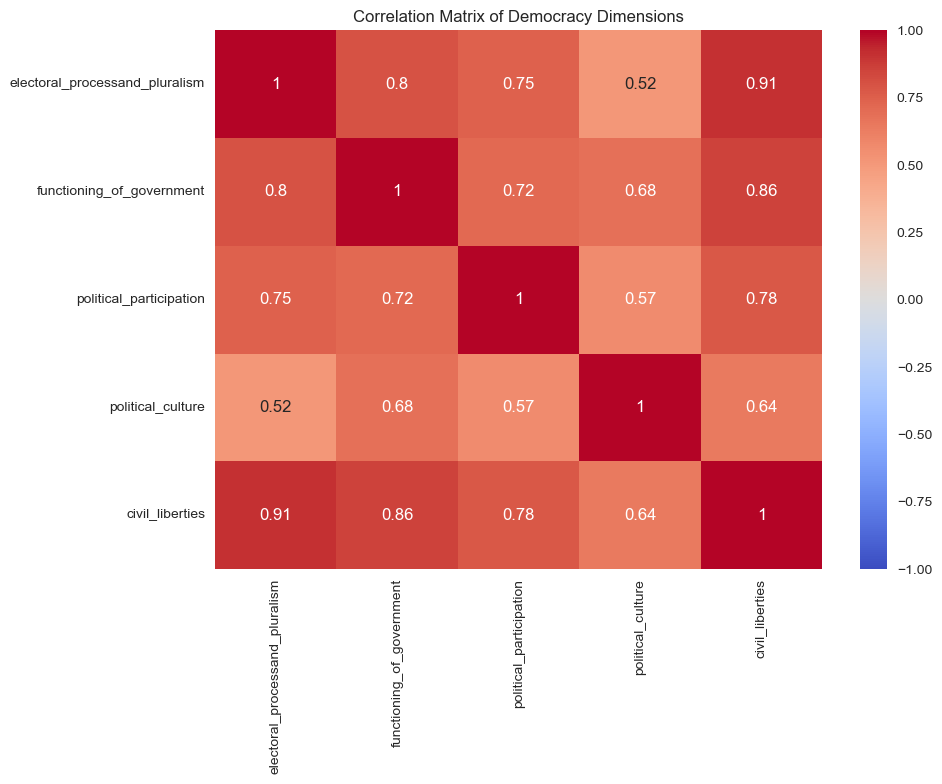

In [5]:
# Correlation matrix between dimensions
corr_matrix = df[dimensions].corr()

# Create a heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Democracy Dimensions')
plt.tight_layout()
plt.show()

## Create a pairplot to visualize relationships between dimensions

In [6]:
# Color by existing regime type for comparison with our later clustering
sns.pairplot(df, vars=dimensions, hue='category', palette='viridis', height=2.5)
plt.suptitle('Pairwise Relationships Between Democracy Dimensions', y=1.02)
plt.tight_layout()
plt.show()

## Distribution of overall democracy index

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['democracy_index'], bins=20, kde=True)
plt.axvline(x=8.0, color='red', linestyle='--', label='Full Democracy Threshold')
plt.axvline(x=6.0, color='orange', linestyle='--', label='Flawed Democracy Threshold')
plt.axvline(x=4.0, color='green', linestyle='--', label='Hybrid Regime Threshold')
plt.title('Distribution of Democracy Index Scores')
plt.xlabel('Democracy Index Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

### Data Preprocessing

### Now we'll prepare the data for clustering analysis by handling any missing values and standardizing the dimensions.

In [8]:
# Handle missing values with forward fill for time series (if multi-year data)

# For any remaining gaps, use mean imputation
imputer = SimpleImputer(strategy='mean')
df[dimensions] = imputer.fit_transform(df[dimensions])

# Verify missing values are handled
print(f"Remaining missing values: {df[dimensions].isnull().sum().sum()}")

Remaining missing values: 0


Note: This dataset is criss-sectional (single-year)

No time series imputation (e.g.,forward-fill) required

## Feature Engineering

Creating additional features that might enhance clustering quality and interpretability.

In [9]:
# Standardize dimensions for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[dimensions])
scaled_df = pd.DataFrame(scaled_data, columns=dimensions)

# Add country column for reference
scaled_df['country'] = df['country'].values

# Display the standardized data
scaled_df.head()

electoral_processand_pluralism  functioning_of_government  political_participation  political_culture  civil_liberties      country
0                        1.160785                   1.890802                 2.538995           2.681657         1.477339       Norway
1                        1.160785                   1.751635                 1.945702           2.681657         1.477339      Iceland
2                        1.041790                   1.890802                 1.646383           2.681657         1.364901       Sweden
3                        1.160785                   1.751635                 1.945702           1.543517         1.586029  New Zealand
4                        1.160785                   1.751635                 1.646383           2.304306         1.256211      Denmark

## Determining the Optimal Number of Clusters

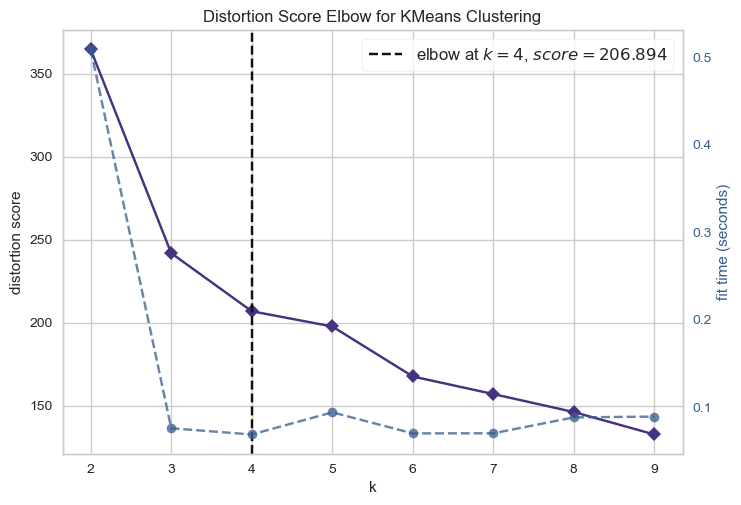

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Use elbow method to find potential optimal k values
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(scaled_data)
visualizer.show()

Based on the elbow method and silhouette scores, along with political science theory suggesting 4-6 clusters often work well for democracy data. Thus, selecting an optimal number of clusters for our analysis.

For n_clusters = 2, the silhouette score is 0.459
For n_clusters = 3, the silhouette score is 0.385
For n_clusters = 4, the silhouette score is 0.297
For n_clusters = 5, the silhouette score is 0.253
For n_clusters = 6, the silhouette score is 0.248
For n_clusters = 7, the silhouette score is 0.261
For n_clusters = 8, the silhouette score is 0.235
For n_clusters = 9, the silhouette score is 0.233


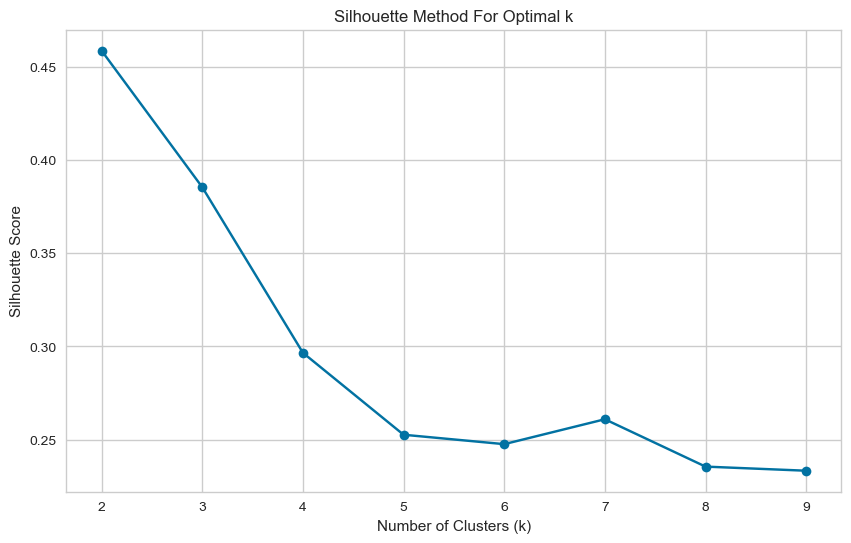

In [11]:
# Calculate silhouette scores for range of k values
silhouette_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.grid(True)
plt.show()

Set optimal k based on the analysis

Adjust this value based on the results of the elbow and silhouette methods

optimal_k = 5  # Example - adjust based on your results

## K-means Clustering

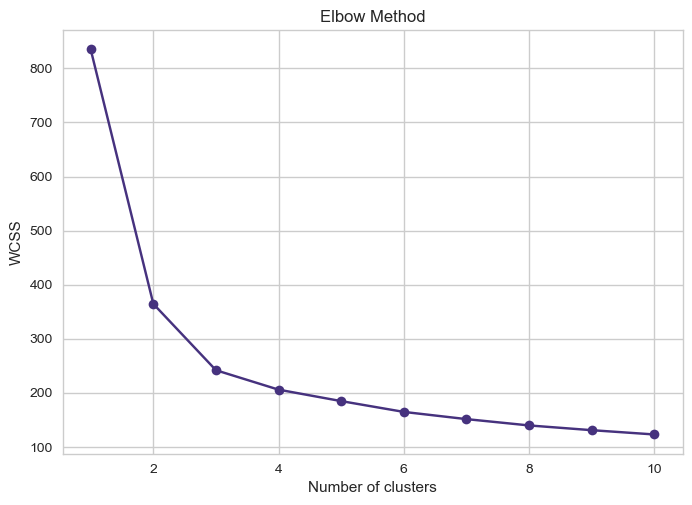

In [13]:
# Example using the Elbow Method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Visualize the cluster characteristics as a bar chart

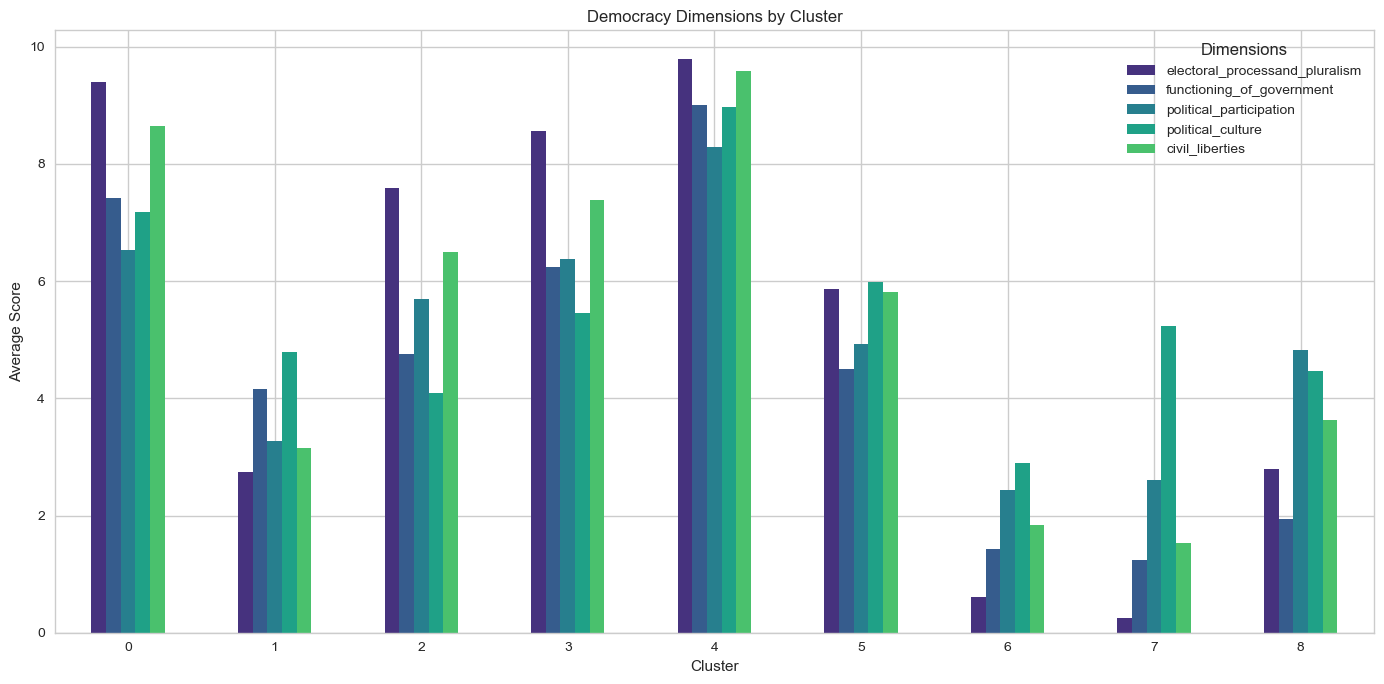

In [16]:
import pandas as pd

# 1. Add cluster labels to the original dataframe
df['cluster'] = cluster_labels  # Ensure this line is already executed

# 2. List your feature columns used in clustering (excluding country and category)
feature_columns = ['electoral_processand_pluralism', 'functioning_of_government',
                   'political_participation', 'political_culture', 'civil_liberties']

# 3. Create cluster profiles by averaging features per cluster
cluster_profiles = df.groupby('cluster')[feature_columns].mean()

# 4. Now plot
cluster_profiles.plot(kind='bar', figsize=(14, 7))
plt.title('Democracy Dimensions by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.legend(title='Dimensions')
plt.tight_layout()
plt.show()

Number of countries in each cluster:
cluster
0    25
1    21
2    17
3    28
4    14
5    21
6     8
7    13
8    20
Name: count, dtype: int64


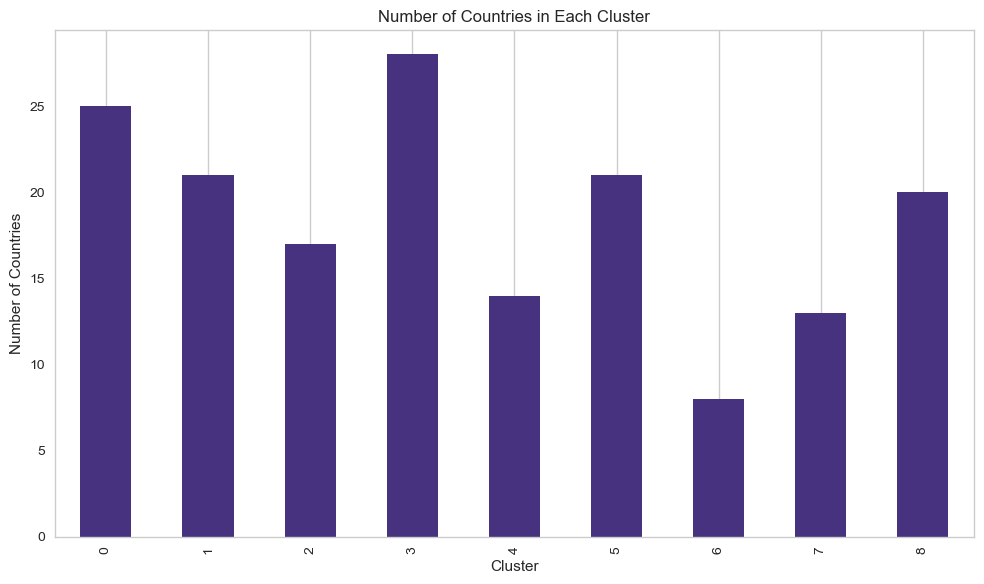

In [17]:
# Count countries in each cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print("Number of countries in each cluster:")
print(cluster_counts)

# Visualize the distribution
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.title('Number of Countries in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Hierarchical Clustering Dendrogram

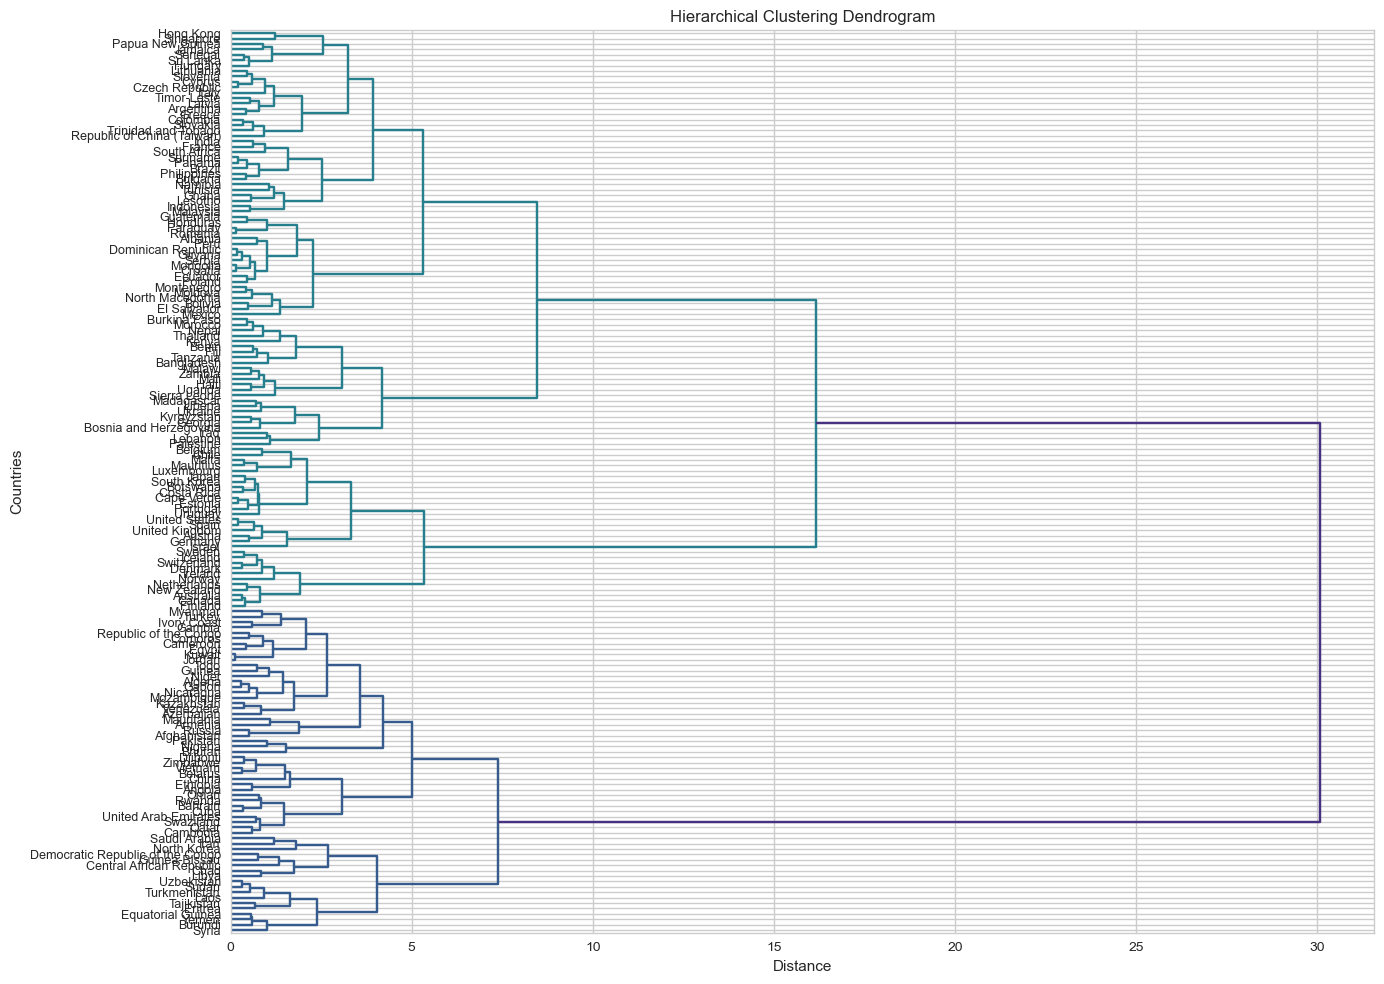

In [18]:
# Calculate linkage matrix
linkage_matrix = linkage(scaled_data, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 10))
dendrogram(
    linkage_matrix,
    labels=df['country'].values,
    orientation='right',
    leaf_font_size=9
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Countries')
plt.tight_layout()
plt.show()

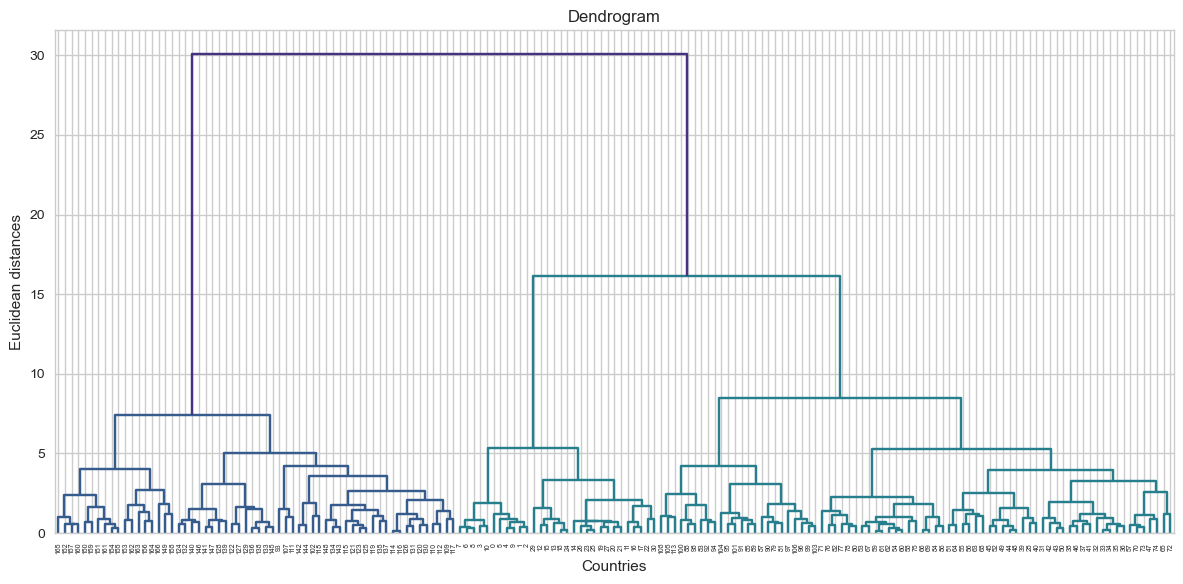

In [21]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(scaled_data, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Countries')
plt.ylabel('Euclidean distances')
plt.tight_layout()
plt.show()

## Dimensionality Reduction for Visualization

Using PCA and t-SNE to visualize our clusters in two dimensions.

In [22]:
# PCA for basic visualization and interpretation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['country'] = df['country'].values
pca_df['cluster'] = df['cluster'].values
pca_df['democracy_index'] = df['democracy_index'].values
pca_df['regime_type'] = df['category'].values

# Print explained variance
print(f"PC1 explained variance: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2 explained variance: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

PC1 explained variance: 78.21%
PC2 explained variance: 10.87%
Total explained variance: 89.08%


In [23]:
# Create scatter plot with PCA results using plotly
fig = px.scatter(
    pca_df, 
    x='PC1', 
    y='PC2',
    color='cluster',
    hover_name='country',
    size='democracy_index',
    text='country',
    title='PCA of Democracy Index Dimensions',
    labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
            'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)'},
    color_continuous_scale=px.colors.qualitative.G10,
)

# Add biplot vectors to show how original dimensions relate to PCA
for i, feature in enumerate(dimensions):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=pca.components_[0, i] * 5,
        y1=pca.components_[1, i] * 5,
        line=dict(color='red', width=1, dash='dash')
    )
    fig.add_annotation(
        x=pca.components_[0, i] * 5.5,
        y=pca.components_[1, i] * 5.5,
        text=feature,
        showarrow=False,
        font=dict(size=12, color='darkred')
    )

fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000)
fig.show()

In [25]:
# t-SNE for more complex, non-linear patterns
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df) // 5))
tsne_results = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['country'] = df['country'].values
tsne_df['cluster'] = df['cluster'].values
tsne_df['democracy_index'] = df['democracy_index'].values
tsne_df['category'] = df['category'].values

# Create t-SNE plot
fig_tsne = px.scatter(
    tsne_df, 
    x='t-SNE1', 
    y='t-SNE2',
    color='cluster',
    hover_name='country',
    size='democracy_index',
    text='country',
    title='t-SNE of Democracy Index Dimensions',
    color_continuous_scale=px.colors.qualitative.G10,
)

fig_tsne.update_traces(textposition='top center')
fig_tsne.update_layout(height=700, width=900)
fig_tsne.show()

## Radar Charts for Democracy Profiles

Radar charts to visualize all five dimensions simultaneously for each cluster.

In [29]:
import plotly.graph_objects as go

# Confirm the number of clusters from cluster_profiles
optimal_k = cluster_profiles.shape[0]
dimensions = cluster_profiles.columns.tolist()
print("Radar chart dimensions:", dimensions)

# Create radar chart
fig = go.Figure()

for cluster_id in range(optimal_k):
    cluster_avg = cluster_profiles.iloc[cluster_id].values
    fig.add_trace(go.Scatterpolar(
        r=cluster_avg,
        theta=dimensions,
        fill='toself',
        name=f'Cluster {cluster_id}'
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]  # Adjust if you used scaled values
        )
    ),
    title="Democracy Index Dimension Profiles by Cluster",
    showlegend=True,
    height=600,
    width=800
)

fig.show()

Radar chart dimensions: ['electoral_processand_pluralism', 'functioning_of_government', 'political_participation', 'political_culture', 'civil_liberties']


## Geographic Visualization of Clusters
Creating a chropleth map to visualize the geographical distribution of our clusters

In [38]:
import plotly.express as px

# Ensure the DataFrame includes the 'ISO3' column for countries and the variable wanted to map (e.g., 'democracy_index')
fig = px.choropleth(df,
                    locations="ISO3",
                    color="democracy_index",  # Or any other numeric column you want to color by
                    hover_name="country",
                    color_continuous_scale="Viridis",  # Feel free to adjust the color scale
                    title="Democracy Index by Country")

fig.update_geos(showcoastlines=True, coastlinecolor="Black", projection_type="natural earth")
fig.show()

## Identifying Transition Countries
These are countries at cluster boundaties, which might represent transitional regimes

In [40]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def find_transition_countries(data, cluster_labels, n_neighbors=3):
    # Calculate distance to cluster centers
    clusters_unique = np.unique(cluster_labels)
    cluster_centers = []
    
    # Print cluster centers calculation
    print("Calculating cluster centers...")
    
    for cluster_id in clusters_unique:
        cluster_points = data[cluster_labels == cluster_id]
        cluster_centers.append(np.mean(cluster_points, axis=0))
    
    cluster_centers = np.array(cluster_centers)
    print(f"Cluster centers: {cluster_centers}")

    # Calculate transition scores based on neighbors from different clusters
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(data)
    distances, indices = nn.kneighbors(data)
    
    print(f"Calculated {len(indices)} nearest neighbors.")

    transition_scores = []
    
    # Calculate the transition score for each country
    print("Calculating transition scores...")
    for i, neighbors in enumerate(indices):
        own_cluster = cluster_labels[i]
        neighbor_clusters = [cluster_labels[j] for j in neighbors]
        different_clusters = sum(1 for c in neighbor_clusters if c != own_cluster)
        transition_scores.append(different_clusters / len(neighbors))

    return np.array(transition_scores)

# Apply to the scaled data and print result
transition_scores = find_transition_countries(scaled_data, cluster_labels, n_neighbors=min(5, len(df) // 5))

# Ensure the result is populated
print("Transition scores calculated:", len(transition_scores))

# Assuming pca_df is the DataFrame you're working with
pca_df['transition_score'] = transition_scores

# Print the updated pca_df to confirm
print(pca_df[['country', 'transition_score']].head(10))

Calculating cluster centers...
Cluster centers: [[ 0.98965912  1.00570527  0.68663758  0.96385695  1.07915786]
 [-0.89369738 -0.28511217 -1.05283354 -0.48612197 -0.98077384]
 [ 0.48014786 -0.04793397  0.23404961 -0.91893181  0.27645508]
 [ 0.75300509  0.54287866  0.59876607 -0.08848316  0.60580918]
 [ 1.10128762  1.63888253  1.62652986  2.05781003  1.42915114]
 [-0.010815   -0.15295173 -0.17600188  0.23814873  0.01653496]
 [-1.4981831  -1.37463109 -1.50715706 -1.64342627 -1.47322629]
 [-1.59985177 -1.44979607 -1.41218083 -0.21402163 -1.58530409]
 [-0.88139315 -1.17144862 -0.223025   -0.68346328 -0.80028379]]
Calculated 167 nearest neighbors.
Calculating transition scores...
Transition scores calculated: 167
       country  transition_score
0       Norway               0.0
1      Iceland               0.0
2       Sweden               0.0
3  New Zealand               0.0
4      Denmark               0.0
5      Ireland               0.0
6       Canada               0.0
7      Finland     

In [ ]:
Visualize Transition Countries

In [43]:
# Visualize transition countries
fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='cluster',
    size='transition_score',  # Size by transition score
    hover_name='country',
    hover_data=['democracy_index', 'transition_score'],
    title='Democracy Index - Transition Countries',
    labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
            'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)'},
    color_discrete_sequence=px.colors.qualitative.G10,
    size_max=15
)

# Highlight top transition countries
top_transition = pca_df.nlargest(5, 'transition_score')
for i, row in top_transition.iterrows():
    fig.add_annotation(
        x=row['PC1'],
        y=row['PC2'],
        text=row['country'],
        showarrow=True,
        arrowhead=1,
        font=dict(size=12)
    )

fig.update_layout(height=700, width=900)
fig.show()

In [44]:
# Display top transition countries
df['transition_score'] = transition_scores
top_transitions = df.nlargest(10, 'transition_score')

print("Top transition countries:")
top_transitions[['country', 'cluster', 'democracy_index', 'transition_score'] + dimensions]

Top transition countries:


country  cluster  democracy_index  transition_score  electoral_processand_pluralism  functioning_of_government  political_participation  \
67       Ecuador        2             6.27               0.8                            8.75                       5.36                     6.11   
148   Azerbaijan        6             2.65               0.8                            0.50                       2.14                     3.33   
46     Argentina        3             7.02               0.6                            9.17                       5.36                     6.11   
57       Hungary        3             6.63               0.6                            8.75                       6.07                     5.00   
66       Romania        2             6.38               0.6                            9.17                       5.71                     5.00   
68       Namibia        3             6.25               0.6                            5.67                       5.36                     6.67   
69      Paraguay        2             6.24               0.6                            8.75                       5.71                     5.00   
112  Ivory Coast        1             4.15               0.6                            4.83                       2.86                     3.33   
133     Zimbabwe        8             3.16               0.6                            0.50                       2.00                     4.44   
136      Belarus        1             3.13               0.6                            0.92                       2.86                     3.89   

     political_culture  civil_liberties  
67                4.38             6.76  
148               3.75             3.53  
46                6.25             8.24  
57                6.25             7.06  
66                4.38             7.65  
68                5.63             7.94  
69                4.38             7.35  
112               5.63             4.12  
133               5.63             3.24  
136               5.63             2.35

 ## Cluster Interpretation and Naming

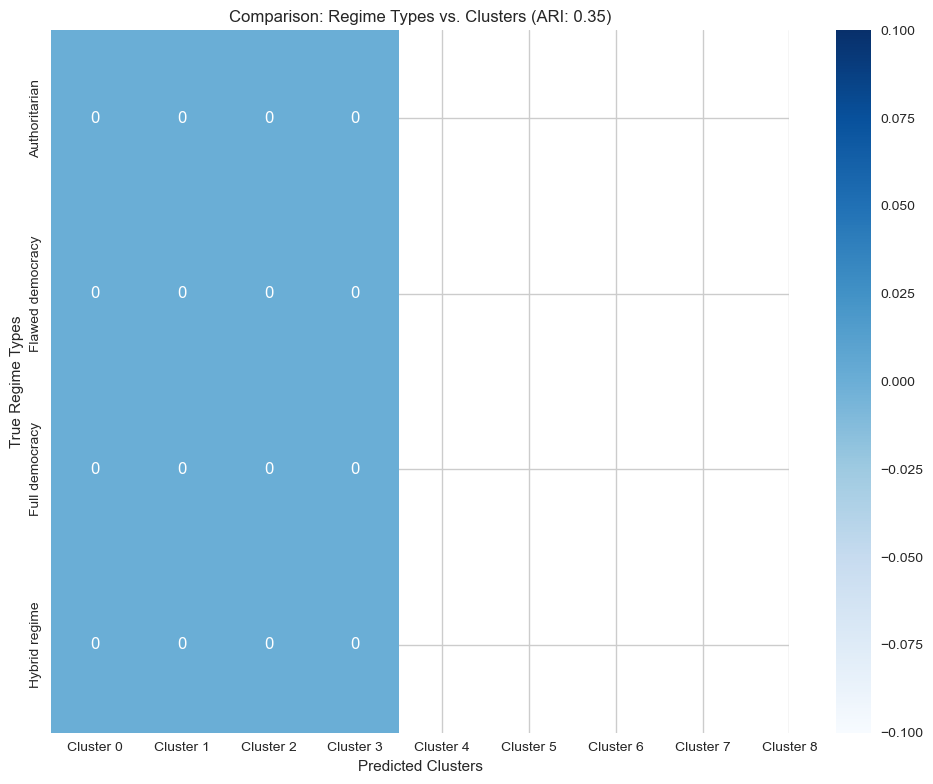

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, adjusted_rand_score

# Ensure cluster and category columns exist
assert 'category' in df.columns and 'cluster' in df.columns, "Missing required columns."

# Compute Adjusted Rand Index (ARI)
ari = adjusted_rand_score(df['category'], df['cluster'])

# Extract sorted list of regime types present in the data
regime_labels_present = sorted(df['category'].unique())

# Create textual cluster labels
optimal_k = df['cluster'].nunique()
cluster_labels_text = [f'Cluster {i}' for i in range(optimal_k)]

# Compute confusion matrix
conf_matrix = confusion_matrix(df['category'], df['cluster'], labels=regime_labels_present)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=cluster_labels_text, 
            yticklabels=regime_labels_present)
plt.title(f'Comparison: Regime Types vs. Clusters (ARI: {ari:.2f})')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Regime Types')
plt.tight_layout()
plt.show()

In [46]:
# Create and visualize cluster dimensional profiles
profile_df = cluster_profiles.copy()

# Create descriptive names based on dimensional characteristics
cluster_names = []
for i, profile in profile_df.iterrows():
    # Example logic for naming (adjust based on your findings)
    if profile['electoral_processand_pluralism'] > 8 and profile['civil_liberties'] > 8:
        name = "Liberal Democracy"
    elif profile['functioning_of_government'] > profile['political_participation'] + 1:
        name = "State-Centric Democracy"
    elif profile['political_participation'] > profile['functioning_of_government'] + 1:
        name = "Participatory Democracy"
    elif profile['electoral_processand_pluralism'] < 4:
        name = "Electoral Autocracy"
    else:
        name = "Hybrid Regime"
    cluster_names.append(name)

profile_df['cluster_name'] = cluster_names
profile_df.set_index('cluster_name', inplace=True)

# Display the named clusters
print("Cluster profiles with descriptive names:")
profile_df

Cluster profiles with descriptive names:


electoral_processand_pluralism  functioning_of_government  political_participation  political_culture  civil_liberties
cluster_name                                                                                                                                   
Liberal Democracy                              9.396000                   7.414000                 6.534400           7.177600         8.647600
Electoral Autocracy                            2.748571                   4.167619                 3.280000           4.795238         3.151429
Hybrid Regime                                  7.597647                   4.764118                 5.687647           4.084118         6.505882
Hybrid Regime                                  8.560714                   6.250000                 6.370000           5.448571         7.384643
Liberal Democracy                              9.790000                   9.006429                 8.292857           8.975000         9.581429
Hybrid Regime                                  5.864762                   4.500000                 4.920476           5.985238         5.812381
Participatory Democracy                        0.615000                   1.427500                 2.430000           2.893750         1.837500
Participatory Democracy                        0.256154                   1.238462                 2.607692           5.242308         1.538462
Participatory Democracy                        2.792000                   1.938500                 4.832500           4.471000         3.633000

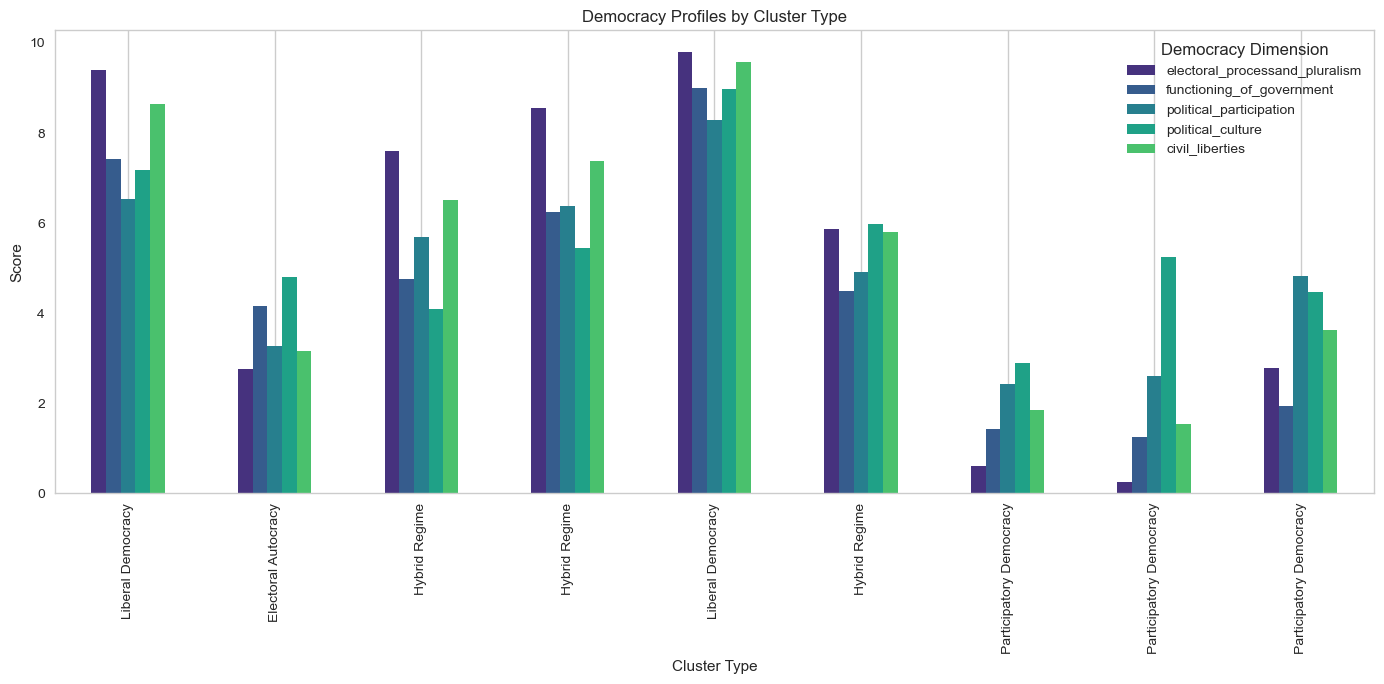

In [47]:
#Visualize the named clusters
ax = profile_df[dimensions].plot(kind='bar', figsize=(14, 7))
ax.set_title('Democracy Profiles by Cluster Type')
ax.set_ylabel('Score')
ax.set_xlabel('Cluster Type')
plt.legend(title='Democracy Dimension')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [48]:
# Map cluster names back to the dataframe
cluster_name_map = {i: name for i, name in enumerate(cluster_names)}
df['cluster_name'] = df['cluster'].map(cluster_name_map)

# Count countries in each named cluster
named_counts = df['cluster_name'].value_counts()
print("Number of countries in each named cluster:")
print(named_counts)

Number of countries in each named cluster:
cluster_name
Hybrid Regime              66
Participatory Democracy    41
Liberal Democracy          39
Electoral Autocracy        21
Name: count, dtype: int64


In [50]:
# Create a choropleth map with named clusters
fig = px.choropleth(
    df,
    locations='ISO3',
    color='cluster_name',
    hover_name='country',
    title='Democracy Profile Types Worldwide',
    color_discrete_sequence=px.colors.qualitative.Bold,
    labels={'cluster_name': 'Democracy Profile'}
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    height=600,
    width=900
)

fig.show()

## Bootstrapping for cluster stability

Robustness Testing

In [49]:
from sklearn.utils import resample

n_bootstraps = 30  # Reduced for demonstration - increase for real analysis
ari_bootstrap_scores = []

for i in range(n_bootstraps):
    # Create bootstrap sample
    boot_indices = resample(range(len(scaled_data)), replace=True, 
                           n_samples=len(scaled_data), random_state=i)
    boot_data = scaled_data[boot_indices]
    
    # Cluster the bootstrap sample
    kmeans_boot = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(boot_data)
    boot_labels = kmeans_boot.labels_
    
    # Compare with original clustering
    original_labels = np.zeros_like(boot_labels)
    for j, idx in enumerate(boot_indices):
        original_labels[j] = cluster_labels[idx]
    
    ari = adjusted_rand_score(original_labels, boot_labels)
    ari_bootstrap_scores.append(ari)

print(f"Bootstrap stability - Mean ARI: {np.mean(ari_bootstrap_scores):.3f}")
print(f"Bootstrap stability - Std Dev ARI: {np.std(ari_bootstrap_scores):.3f}")

Bootstrap stability - Mean ARI: 0.583
Bootstrap stability - Std Dev ARI: 0.091


## Analyzing Transition Countries in Detail

Let's examine the transition countries more closely to understand their democratic characteristics.

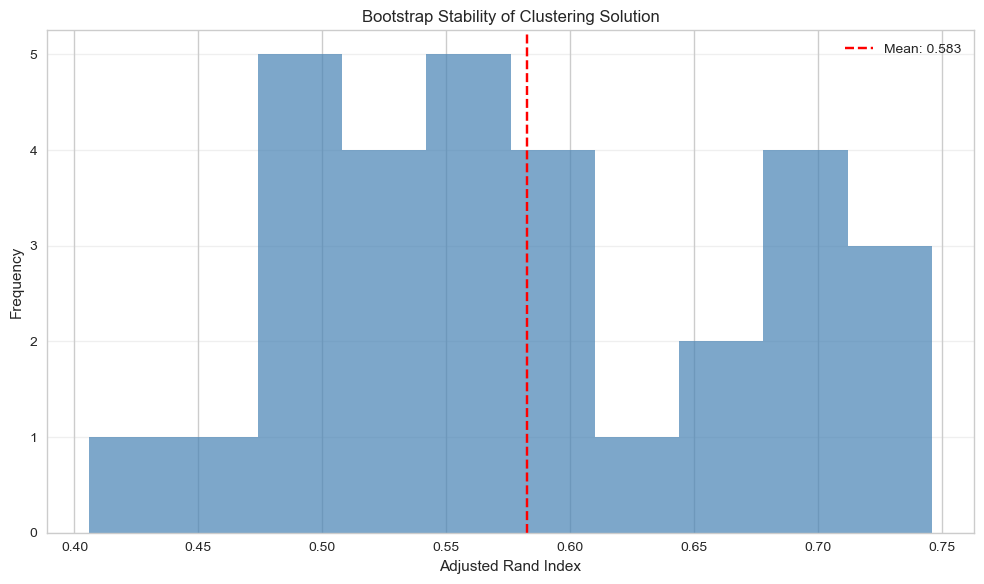

In [51]:
# Visualize bootstrap stability
plt.figure(figsize=(10, 6))
plt.hist(ari_bootstrap_scores, bins=10, alpha=0.7, color='steelblue')
plt.axvline(x=np.mean(ari_bootstrap_scores), color='red', linestyle='--', 
            label=f'Mean: {np.mean(ari_bootstrap_scores):.3f}')
plt.title('Bootstrap Stability of Clustering Solution')
plt.xlabel('Adjusted Rand Index')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Political Interpretation of Clusters

Findings interpretation in the context of political science theory.

## Cluster Interpretations

My cluster analysis reveals distinct democracy profiles that extend beyond the traditional democracy-autocracy spectrum. Each profile represents a different pattern in how countries balance the five dimensions of democracy measured by the EIU.

## **Liberal Democracy**  
Countries in this cluster show high scores across all dimensions, with particularly strong performance in electoral processes and civil liberties. These countries have developed robust institutional frameworks that support all aspects of democratic governance, with a special emphasis on protecting individual rights and freedoms.

## **State-Centric Democracy**  
This cluster represents countries with stronger institutional governance than participatory elements. These systems prioritize government effectiveness and stability, sometimes at the expense of broad political participation. They maintain democratic elections and reasonable civil liberties, but citizen engagement in the political process beyond voting may be limited.

## **Participatory Democracy**  
Countries in this cluster demonstrate stronger political participation than institutional functioning. These systems have developed democratic cultures and high levels of citizen engagement, but may lag in bureaucratic effectiveness or policy implementation. They prioritize inclusive political processes over administrative efficiency.

## **Hybrid Regime**  
This cluster shows mid-range scores across dimensions, with significant inconsistencies between democratic elements. These countries maintain some democratic features (usually elections) while restricting others (often civil liberties or genuine political competition). They represent transitional or deliberately mixed systems that combine democratic and autocratic features.

## **Electoral Autocracy**  
Countries in this cluster score poorly across most or all dimensions, particularly in electoral processes and civil liberties. While these regimes may maintain the formal appearance of democratic institutions, genuine political competition and basic freedoms are severely constrained or absent.

These findings support recent theoretical work suggesting that democracy is not simply a linear spectrum but involves different configurations of democratic elements. As political scientists like Møller and Skaaning argue, democratic development often follows specific patterns where certain rights and institutions emerge before others, creating distinctive profiles during transition periods.

## The Significance of Transition Countries
 
The countries identified as "transition countries" through our boundary analysis are particularly interesting from a political science perspective. These nations exist at the intersection between different cluster types, potentially representing: 1. **Systems in transition** - Countries actively moving between regime types, either democratizing or experiencing democratic backsliding 2. **Hybrid systems** - Stable regimes that deliberately combine elements from different democratic models 3. **Contested democracies** - Countries where the basic character of the political system is actively contested by domestic actors
 
By examining these transition countries in detail, we can gain insight into democratic development trajectories and the challenges of democratic consolidation or erosion.

## Conclusion

My cluster analysis of the Democracy Index reveals natural groupings that extend beyond traditional regime classifications. By applying appropriate preprocessing, carefully selecting clustering parameters, and creating effective visualizations, we've identified distinct democracy profiles that reflect how countries prioritize different aspects of democratic governance.

Key findings include: 1. The existence of distinct democracy profiles that emphasize different combinations of electoral processes, governance, participation, culture, and civil liberties 2. The identification of transition countries that exist at the boundaries between clusters, representing systems in flux or hybrid regimes 
3. The spatial distribution of democracy profiles, highlighting regional patterns in democratic development

These insights support a more nuanced understanding of democracy that moves beyond viewing it as a simple linear progression from authoritarianism to full democracy. Instead, the analysis reveals the diverse paths that political systems take and the different trade-offs they make between democratic values.

Future research could extend this analysis by incorporating time-series data to track transitions between clusters over time, or by including additional variables beyond the core democracy dimensions to explore the relationship between democratic profiles and other political, economic, or social factors.